In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from lmfit import Model

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

In [3]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 150

hue_order = ["VAE", "PCA", "nanoTxformer", "RandomProjection"]
c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]

In [4]:
df_gaussian = pd.read_csv('../results/Caltech101_Gaussian.csv', index_col=0)
df_resolution = pd.read_csv('../results/Caltech101_Resolution.csv', index_col=0)
classes = sorted(df_gaussian[df_gaussian['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']

Protein 114 3344.759294079361 4.059468049195221
Protein 228 4534.103980752206 4.307777136271579
Protein 570 5759.759468589475 4.499756135013828
Protein 1140 6214.200172347127 4.61467426663943
Protein 2509 7598.859379275228 4.80227044919361
Protein 5247 9783.508739300058 5.049847491517053
Protein 11407 10754.245652782727 5.164541912638616
Protein 24525 9334.087350179312 5.124540256330305
Protein 52929 9999.5714177263 5.193109819753624
Protein 114072 12518.296127511914 5.292018006609453


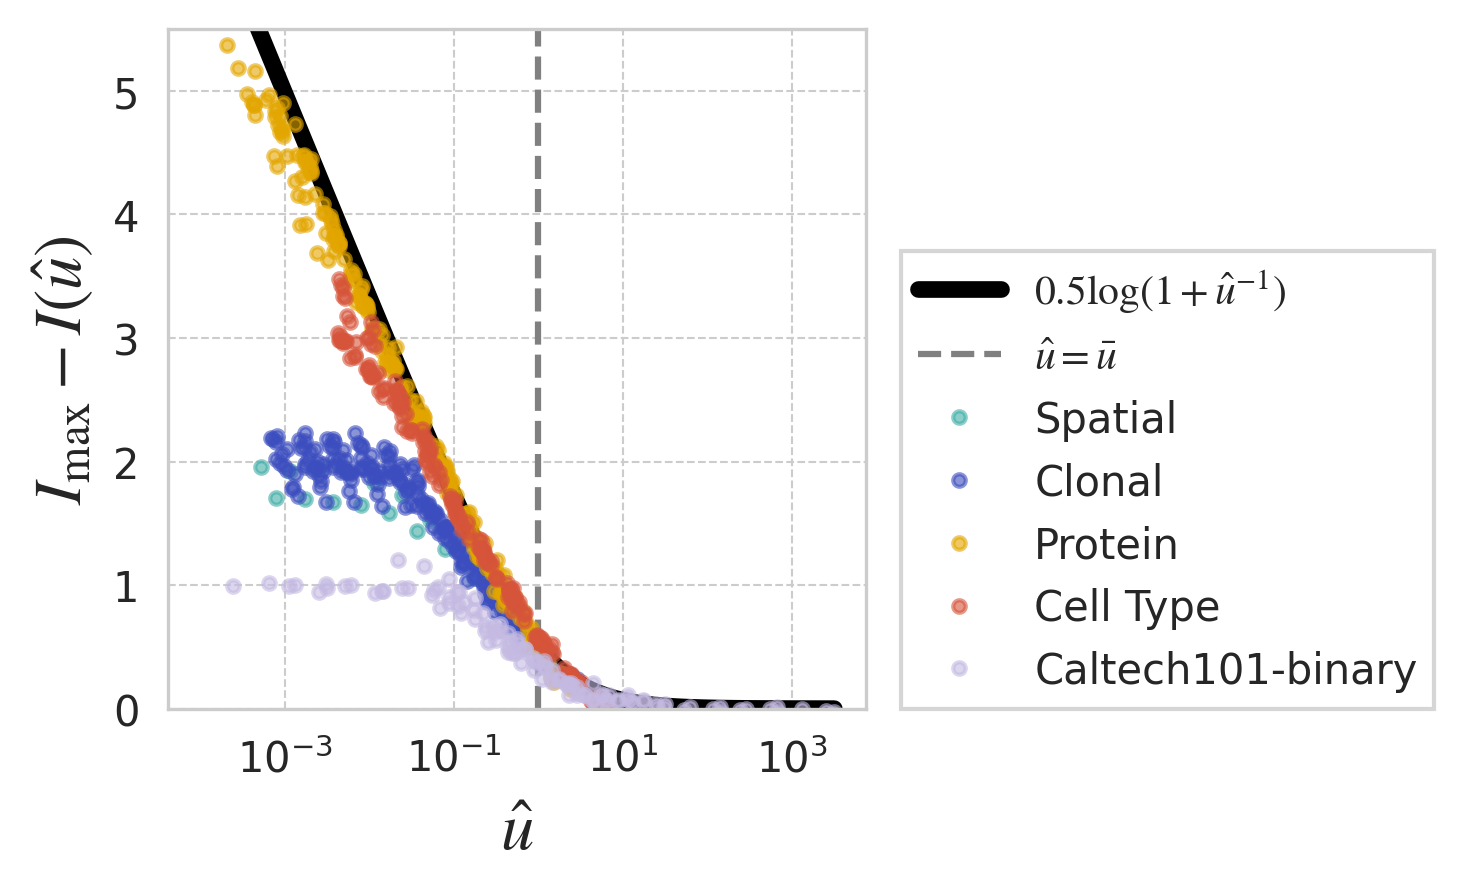

In [6]:
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(3, 3), dpi=300)
dfs = [merf_df, larry_df, cite_df, cite_df]
metrics = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']
names = ['Spatial', 'Clonal', 'Protein', 'Cell Type']

lw = 0
alpha = 0.6
ms = 3

xs = np.logspace(-4, 3.5, 100)
ys = 0.5*np.log2(1 + 1/xs)
axs.plot(xs, ys, color='black', linestyle='-', alpha=1, lw=4,
         label=r'$0.5 \log (1 + \hat{u}^{-1})$')

axs.plot([1, 1], [0, 5.5], color='grey', linestyle='--', alpha=1, label=r'$\hat{u} = \bar{u}$')

for df, metric, name in zip(dfs, metrics, names):
    for cell_number in df['Cell number'].unique():
        N_cells = df[df['Cell number'] == cell_number]

        for i, method in enumerate(hue_order[:2]):
            x_data = N_cells[N_cells['Method']== method]['UMI per cell']
            ydata = N_cells[N_cells['Method']== method][metric]

            model = Model(info_scaling)
            params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
            params['A'].min = 0  # set bounds
            params['B'].min = 0

            # fit model
            result = model.fit(ydata, params, x=x_data)

            if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

                if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
            

                    x_bar = 1/result.params['A'].value

                    x_hat = x_data / x_bar

                    I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

                    axs.plot(x_data / x_bar, I_max-ydata, color=pretty_palette[names.index(name)], marker='o',
                            alpha=alpha, markersize=ms, label=name, lw=lw)
                    
                    if method == 'VAE' and metric == 'Protein MI':
                        print(name, cell_number, 1/result.params['A'].value, 0.5*np.log2(result.params['B'].value/result.params['A'].value))
                    
                    

df = df_resolution

for i, x in enumerate(classes[:-1]):
    # prepare data
    x_data = (1 / (df[df['Class label'] == x]['Factor']))
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

        if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
            

            x_bar = 1/result.params['A'].value

            x_hat = x_data / x_bar

            I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

            axs.plot(x_data / x_bar, I_max-y_data, color=c6[0], marker='o',
                    alpha=alpha, markersize=ms, label='Caltech101-binary', lw=lw)
            

df = df_gaussian

for i, x in enumerate(classes[:-1]):
    # prepare data
    x_data = (1 / (df[df['Class label'] == x]['Scale'])**2)
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    if result.params['A'].stderr is not None and result.params['B'].stderr is not None:

        if result.params['A'].stderr < result.params['A'].value and result.params['B'].stderr < result.params['B'].value:
            

            x_bar = 1/result.params['A'].value

            x_hat = x_data / x_bar

            I_max = 0.5 * np.log2(result.params['B'].value/result.params['A'].value)

            axs.plot(x_data / x_bar, I_max-y_data, color=c6[0], marker='o',
                    alpha=alpha, markersize=ms, label='Caltech101-binary', lw=lw)





plt.xscale('log')
plt.ylabel(r'$I_{\max} - I(\hat{u})$',fontsize=16)
plt.xlabel(r'$\hat{u}$', fontsize=16)
plt.ylim(0, 5.5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(1.05, 0.0))